<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

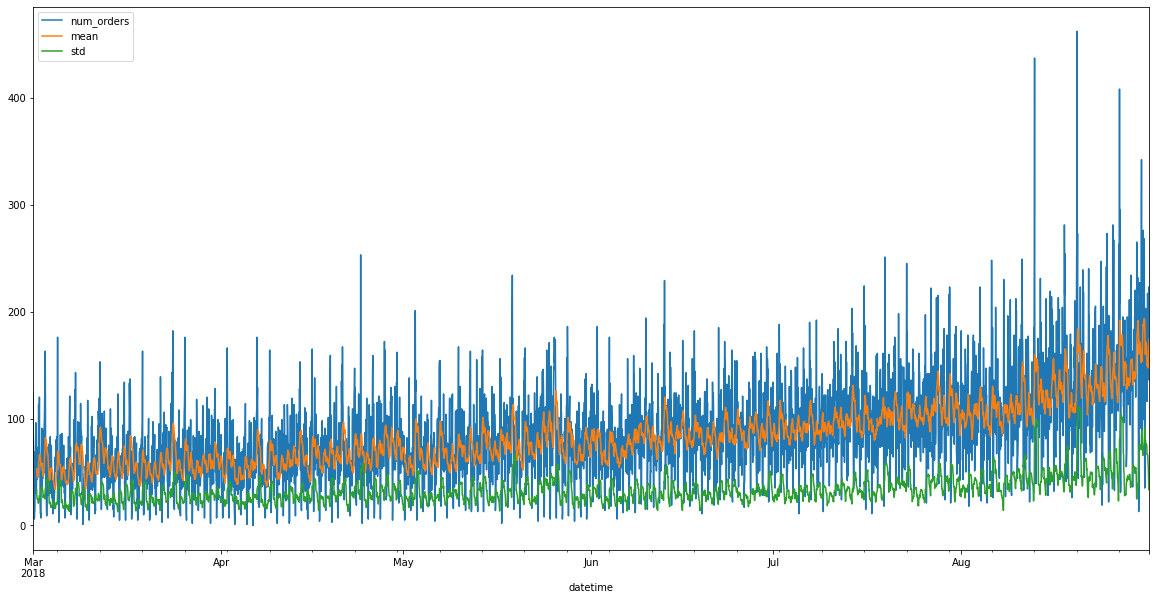

In [3]:
#Проверка, является ли временной ряд стационарным
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot(figsize=(20,10))
df = df.drop(['std', 'mean'], axis=1)

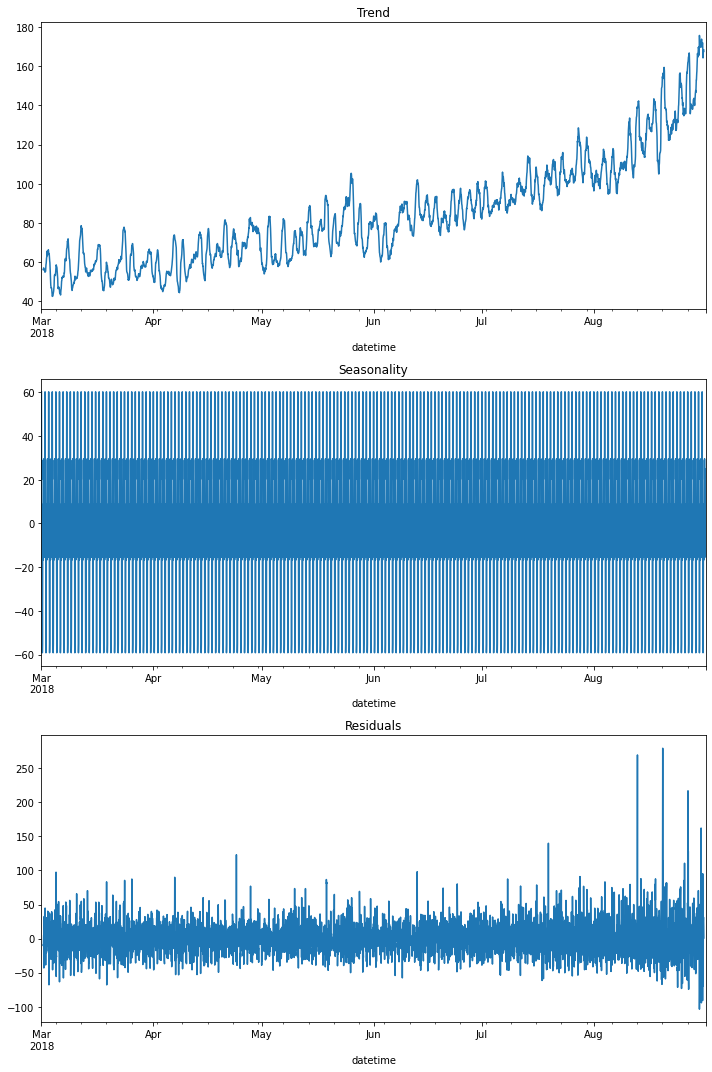

In [4]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд восходящий на увеличение количества заказов в час, сезонной составляющей нет. Сделаем его таковым через разности значений

<AxesSubplot:xlabel='datetime'>

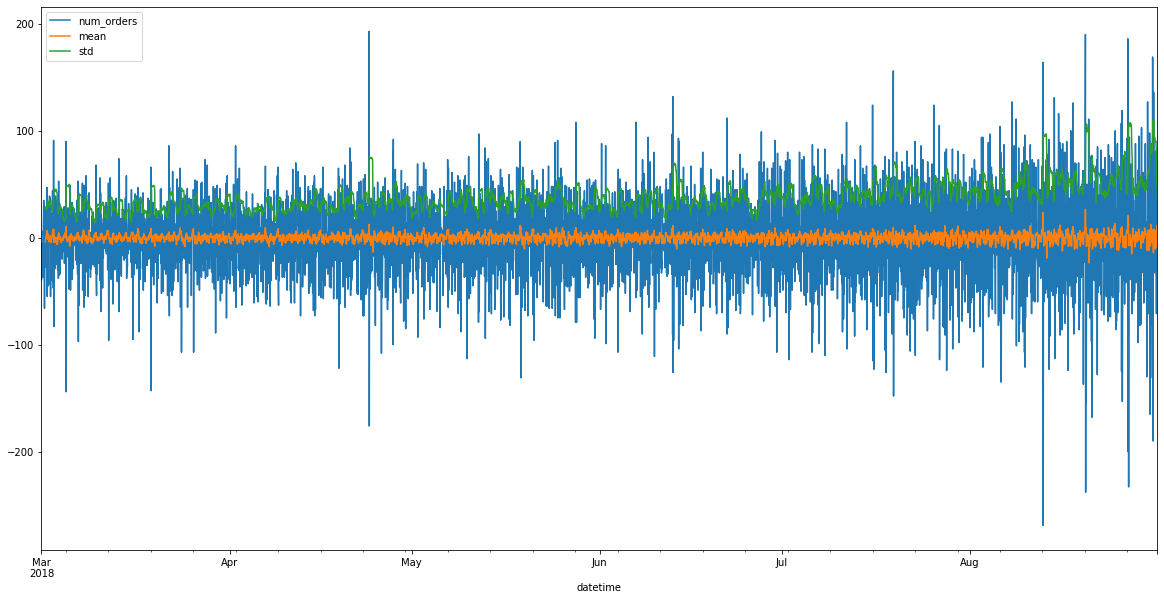

In [5]:
df = df - df.shift()
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot(figsize=(20,10))

Создадим некоторые признаки для улучшения прогнозирования

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

df = df.drop(['std', 'mean'], axis=1)
df = make_features(df, 24, 24)
df.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,3,1,3,-39.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,3,1,3,-14.0,-39.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,3,1,3,-5.0,-14.0,-39.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение

In [7]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()


features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

In [8]:
%%time
#Подбор лучшей модели для линейной регрессии
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(LinearRegression(), parameters, cv=tscv,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_lr = grid.best_estimator_
print(f'Лучшие параметры линейной регрессии {grid.best_params_}')
print(f'Лучший rmse линейной регрессии {abs(grid.best_score_):.2f}')

Лучшие параметры линейной регрессии {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Лучший rmse линейной регрессии 27.64
CPU times: user 1.97 s, sys: 2.72 s, total: 4.69 s
Wall time: 4.69 s


In [9]:
%%time
#Дерево решений - подбор модели
parameters = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
    "min_samples_split": [10, 20, 40], 
    "min_samples_split": [10, 20, 40], 
    "max_leaf_nodes": [5, 20, 100]
}
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(DecisionTreeRegressor(), parameters, cv=tscv,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_dt = grid.best_estimator_
print(f'Лучшие параметры дерева решений {grid.best_params_}')
print(f'Лучший rmse дерева решений {abs(grid.best_score_):.2f}')

Лучшие параметры дерева решений {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_split': 20}
Лучший rmse дерева решений 31.21
CPU times: user 4.46 s, sys: 76 ms, total: 4.54 s
Wall time: 4.6 s


In [10]:
%%time
#Случайный лес - подбор модели
parameters = { 
    "n_estimators"      : [10, 100],
    "max_features"      : ["auto", "sqrt", "log2"],
    "min_samples_split" : [2],
    "max_depth": [None, 1, 2, 3],
    "bootstrap": [True, False],
    } 
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(RandomForestRegressor(), parameters, cv=tscv,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_rf = grid.best_estimator_
print(f'Лучшие параметры модели случайного леса {grid.best_params_}')
print(f'Лучший rmse модели случайного леса  {abs(grid.best_score_):.2f}')

Лучшие параметры модели случайного леса {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
Лучший rmse модели случайного леса  28.44
CPU times: user 51.9 s, sys: 244 ms, total: 52.2 s
Wall time: 52.2 s


In [11]:
%%time
#LGBM - подбор модели
tscv = TimeSeriesSplit(n_splits=3)
parameters = { 
    'num_leaves': [7, 14, 21, 28],
    'learning_rate': [0.1, 0.03],
    'max_depth': [-1, 3],
    'n_estimators': [50, 100, 200],
    } 
grid = GridSearchCV(lgb.LGBMRegressor(), parameters, cv=tscv,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_LightGBM = grid.best_estimator_
print(f'Лучшие параметры модели LGBM {grid.best_params_}')
print(f'Лучший rmse модели LGBM  {abs(grid.best_score_):.2f}')

Лучшие параметры модели LGBM {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 14}
Лучший rmse модели LGBM  27.72
CPU times: user 19min 22s, sys: 4.04 s, total: 19min 26s
Wall time: 19min 36s


In [12]:
%%time
#XGB - подбор модели
tscv = TimeSeriesSplit(n_splits=3)
parameters = { 
    'reg_alpha': np.arange(0.1, 0.4, 0.1),
    'learning_rate': np.arange(0.1, 0.6, 0.1),
    'max_depth': range(2, 11, 2),
    'n_estimators': range(10, 41, 10),
    } 
grid = GridSearchCV(xgb.XGBRegressor(random_state=12345), parameters, cv=tscv,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_xgb = grid.best_estimator_
print(f'Лучшие параметры модели XGB {grid.best_params_}')
print(f'Лучший rmse модели XGB {abs(grid.best_score_):.2f}')

Лучшие параметры модели XGB {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 40, 'reg_alpha': 0.30000000000000004}
Лучший rmse модели XGB 28.22
CPU times: user 22min 31s, sys: 8.06 s, total: 22min 39s
Wall time: 22min 50s


Наименьшую ошибку (RMSE = 18.87) показала модель на базе LGBM, проверим ее на тестовой выборке.

## Тестирование

In [36]:
df_pred['num_orders'].values - target_test.values
df_diff = target_test.copy()

array([ 7.70361523e+00, -4.70027360e+01,  2.60633376e-01, -1.54755742e+01,
        4.36189925e-01,  1.54032921e+01,  1.89972606e+01, -6.11927673e+01,
        4.27057749e+01,  1.84529281e+01,  2.63745803e+01, -6.93666445e+01,
        1.46676786e+02, -1.17683387e+02,  1.92139093e+01,  4.54431633e+01,
        8.72842788e+00,  1.30679441e+01, -1.53822208e+00,  1.65511768e+00,
       -2.39013932e+01, -1.52236181e+01, -6.40547534e+00,  5.90848602e+01,
       -7.51503035e+00, -3.03588168e+00,  3.18058583e+01, -9.38231666e+00,
        3.54472703e+01, -1.81707239e+01,  2.20540001e+01, -1.10173602e+01,
        3.69329717e+01, -8.02854803e+01, -5.64291279e+01,  9.51958103e+01,
       -3.36803975e+01,  1.59911344e+01, -1.20961873e+01, -3.87302349e+00,
        3.36626064e+01,  2.49616660e+01, -2.53580136e+01,  2.29605655e+01,
       -2.61288390e+01,  3.53305391e+01,  3.26523241e+01, -4.70591563e+00,
       -2.63007040e+01,  2.39008271e+01, -8.33614280e+01,  6.59450837e-01,
        7.32386550e+00, -

RMSE на тестовой выборке: 44.24


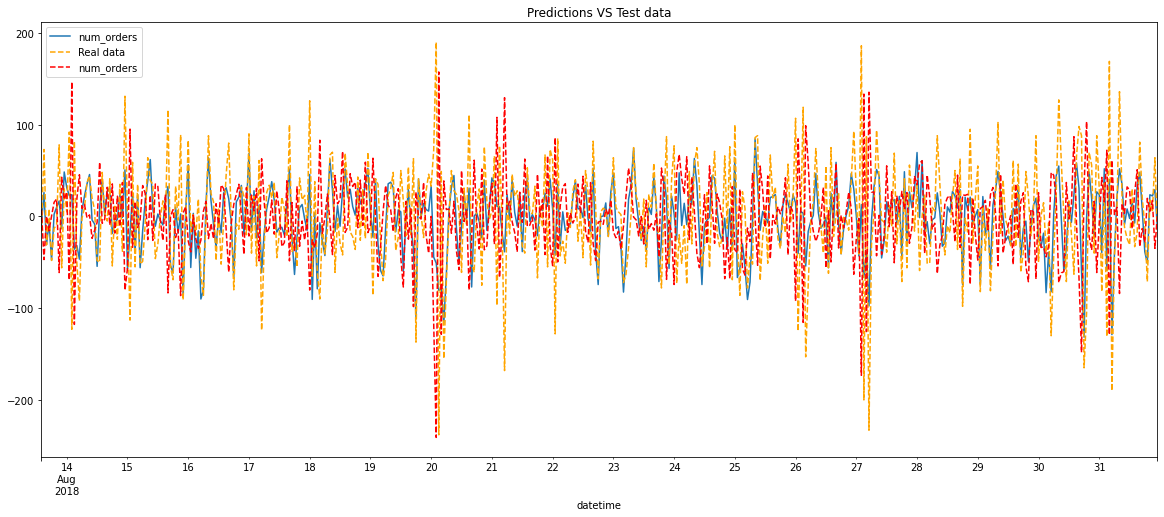

CPU times: user 441 ms, sys: 7.91 ms, total: 449 ms
Wall time: 418 ms


In [44]:
%%time
predictions = model_LightGBM.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
print("RMSE на тестовой выборке: %.2f" % rmse)

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot()
plt.title('Predictions VS Test data')

df_pred = pd.DataFrame(predictions, index = features_test.index, columns = ['num_orders'])
df_diff = df_pred.copy()
df_diff = pd.DataFrame(df_pred['num_orders'].values - target_test.values, index = features_test.index, columns = ['num_orders'])


df_pred.plot(ax=ax1, label='Predicted data')
target_test.plot(ax=ax1, linestyle='--', c='orange', label='Real data')
df_diff.plot(ax=ax1, linestyle='--', c='red', label='Difference')
ax1.legend()
plt.show()

Цель достигнута: модель подобрана, RMSE на тестовой выборке не больше 48. Из графика видно, что предсказания довольно неплохо повторяются реальные данные тестовой выборки, в основном ошибаясь на пиках.